Saving 1730285881-Airbnb_Open_Data.xlsx to 1730285881-Airbnb_Open_Data (9).xlsx
📂 Using dataset: 1730285881-Airbnb_Open_Data (9).xlsx
✅ Dataset Loaded Successfully!

📊 Dataset Preview:


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


✅ Cleaned dataset: 102005 rows, 26 columns



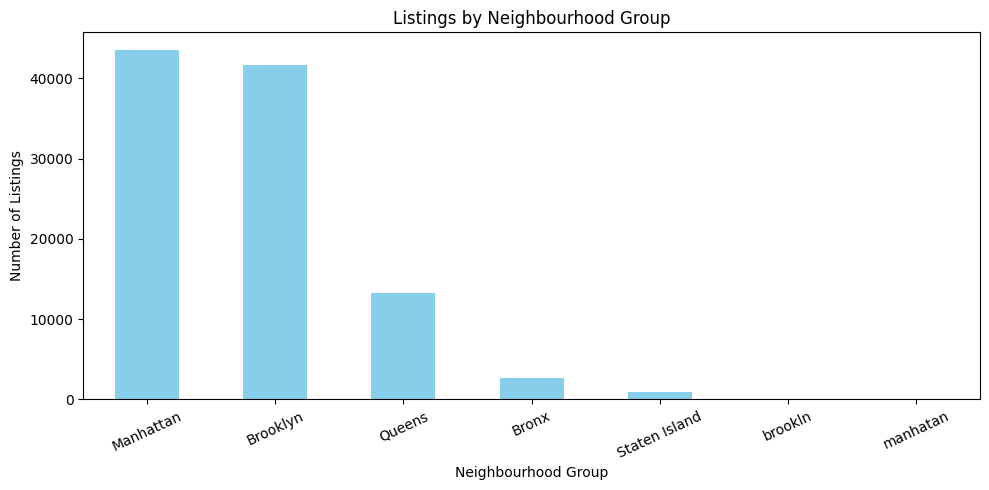

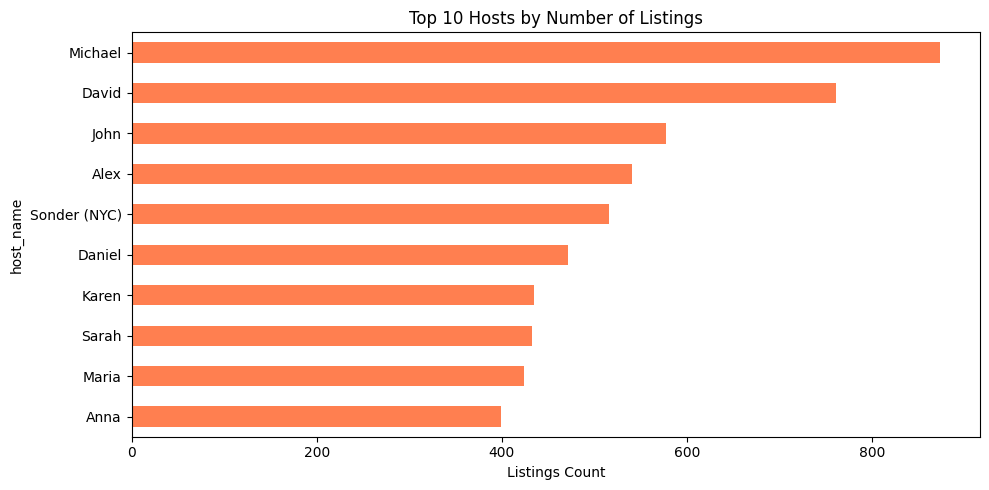

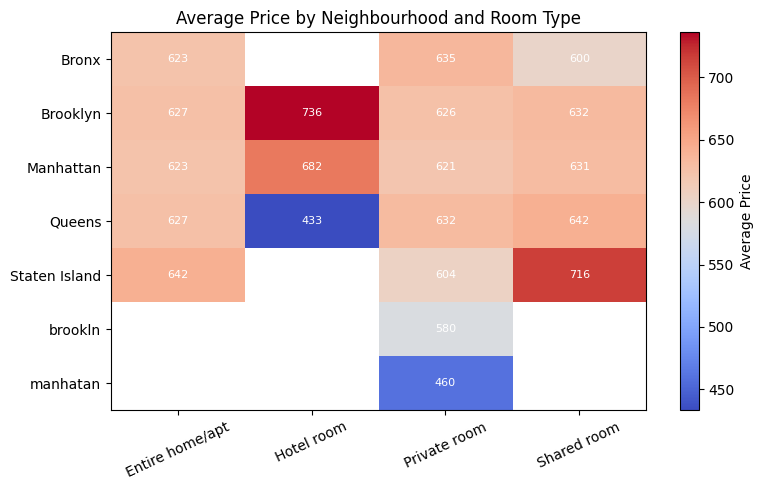

📈 Model Performance:
Linear Regression → RMSE: 332.12, R²: -0.000
Random Forest → RMSE: 332.34, R²: -0.001


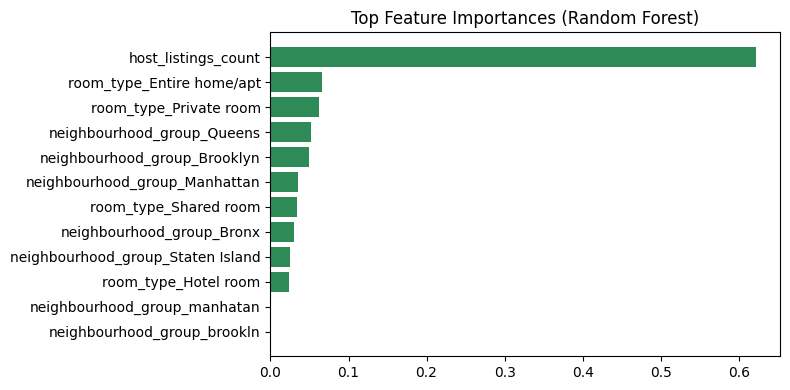

,Feature,Importance
11,host_listings_count,0.621816
7,room_type_Entire home/apt,0.065958
9,room_type_Private room,0.062734
3,neighbourhood_group_Queens,0.051876
1,neighbourhood_group_Brooklyn,0.049014
2,neighbourhood_group_Manhattan,0.035843
10,room_type_Shared room,0.033918
0,neighbourhood_group_Bronx,0.030038
4,neighbourhood_group_Staten Island,0.025298
8,room_type_Hotel room,0.023154


In [12]:
from google.colab import files
uploaded = files.upload()
===================================================== #

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------------------------------
# STEP 1 — Read the uploaded dataset
# -----------------------------------------------------
uploaded_filename = list(uploaded.keys())[0]
print(f"📂 Using dataset: {uploaded_filename}")

if uploaded_filename.endswith('.xlsx'):
    df = pd.read_excel(uploaded_filename)
else:
    df = pd.read_csv(uploaded_filename)

print("✅ Dataset Loaded Successfully!\n")
print("📊 Dataset Preview:")
display(df.head())

# -----------------------------------------------------
# STEP 2 — Basic cleaning and renaming
# -----------------------------------------------------
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Rename columns to match pipeline expectations
df = df.rename(columns={
    'calculated_host_listings_count': 'host_listings_count',
    'room_type': 'room_type',
    'neighbourhood_group': 'neighbourhood_group'
})

# Drop rows with missing critical columns
df = df.dropna(subset=['price', 'host_listings_count', 'neighbourhood_group', 'room_type'])
print(f"✅ Cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns\n")

# -----------------------------------------------------
# STEP 3 — Visualization (Graphs)
# -----------------------------------------------------
# Listings by Neighbourhood Group
plt.figure(figsize=(10,5))
df['neighbourhood_group'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Listings by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# Top 10 Hosts by Number of Listings
if 'host_name' in df.columns:
    top_hosts = df['host_name'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    top_hosts.plot(kind='barh', color='coral')
    plt.title('Top 10 Hosts by Number of Listings')
    plt.xlabel('Listings Count')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Heatmap: Average Price by Neighbourhood and Room Type
if 'room_type' in df.columns and 'neighbourhood_group' in df.columns:
    pivot = df.pivot_table(values='price', index='neighbourhood_group', columns='room_type', aggfunc='mean')
    plt.figure(figsize=(8,5))
    plt.imshow(pivot, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Average Price')
    plt.title('Average Price by Neighbourhood and Room Type')
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=25)
    plt.yticks(range(len(pivot.index)), pivot.index)
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            plt.text(j, i, f"{pivot.iloc[i, j]:.0f}", ha='center', va='center', fontsize=8, color='white')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# STEP 4 — Machine Learning Model
# -----------------------------------------------------
# Features to use
features = ['neighbourhood_group', 'room_type', 'host_listings_count']
X = df[features]
y = df['price']

# Define categorical and numerical columns
categorical_features = ['neighbourhood_group', 'room_type']
numeric_features = ['host_listings_count']

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Define pipelines for models
pipeline_lr = Pipeline(steps=[('pre', preprocessor), ('model', LinearRegression())])
pipeline_rf = Pipeline(steps=[('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)

# Train Random Forest
pipeline_rf.fit(X_train, y_train)
pred_rf = pipeline_rf.predict(X_test)

# Evaluate models (RMSE & R²)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

print("📈 Model Performance:")
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}")
print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

# -----------------------------------------------------
# STEP 5 — Feature Importance (Random Forest)
# -----------------------------------------------------
ohe = pipeline_rf.named_steps['pre'].named_transformers_['cat']
ohe_cols = list(ohe.get_feature_names_out(categorical_features))
feature_names = ohe_cols + numeric_features

importances = pipeline_rf.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False).head(12)

plt.figure(figsize=(8,4))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Importance'][::-1], color='seagreen')
plt.title('Top Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

display(feat_imp)


